In [61]:
import os
import json
import numpy as np
import music21 as m21
import tensorflow.keras as keras

KERN_DATASET_PATH = '/home/pain/proj/music-generation/deutschl/essen/europa/deutschl/test'
SAVE_DIR = '/home/pain/proj/music-generation/dataset'
SINGLE_FILE_DATASET = "/home/pain/proj/music-generation/file_dataset"
MAPPING_FILE = '/home/pain/proj/music-generation/mapping.json'
ACCEPTABLE_DURATIONS = [
    0.25,
    0.5,
    0.75,
    1.0,
    1.5,
    2,
    3,
    4
]

In [62]:
def load_songs(dataset_path):
    songs = []

    # go through all the files in dataset and load them with m21
    for path, _, files in os.walk(dataset_path):
        for file in files:
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)

    return songs

In [63]:
# to train model only acceptable duration song
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [64]:
# Transposes song to C maj/A min key because there are 24 keys
def transpose(song):
    # get key from the song
    parts = song.getElementsByClass(m21.stream.Part)
    measure_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measure_part0[0][4]

    # not having the key so estimate it using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition eg Bmaj -> Cmaj
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    transposed_song = song.transpose(interval)

    return transposed_song

In [65]:
def encode_song(song, time_step=0.25):
    # p = 60, d = 1.0/0.25 = 4 -> [60, "_", "_", "_"] 

    encoded_song = []
    for event in song.flat.notesAndRests:
        #handle notes

        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60

        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)

        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")
    
    # typecast encoded song to a str
    encode_song_string = " ".join(map(str, encoded_song))

    return encode_song_string


In [66]:
def preprocess(dataset_path):
    print("Loading songs...")
    songs = load_songs(dataset_path)
    print(f"Loaded {len(songs)} songs.")

    for i, song in enumerate(songs):
        # filter out songs that have non-acceptable duration
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue

        song = transpose(song)
        encoded_song = encode_song(song)

        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song) 

In [67]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()

    return song

def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length=64):
    # load encoded songs and add delimiters
    new_song_delimiter = "/ " *  sequence_length
    songs = ""

    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter
    
    songs = songs[:-1]    

    # save string that contains all dataset
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs


In [68]:
def create_mapping(songs, mapping_path):
    mappings = {}

    # identify the vocabulary
    songs = songs.split(" ")
    vocabulary = list(set(songs))

    # create mappings
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    # save vocabulary to a json file
    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)


In [69]:
def convert_songs_to_int(songs):
    int_songs = []

    #load mappings
    with open(MAPPING_FILE, "r") as fp:
        mappinps = json.load(fp)

    # cast song string to a list
    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappinps[symbol])

    return int_songs

In [70]:
def generating_training_sequences(sequence_length=64):
    # [11,12,13,14, ...] -> input: [11,12], target: [13]
    
    # load songs and map them to int
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)

    # generate the training sequences
    inputs = []
    targets = []
    
    num_sequences = len(int_songs) - sequence_length
    # sliding window
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences, help in categorical data
    # inputs: (# of sequences, sequence length)
    # [[0,1,2], [1,1,2]] -> [[[1,0,0], [0,1,0], [0,0,1]], [[0,1,0], [0,1,0], [0,0,1]]
    vocabulary_size = len(set(int_songs))
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets


Loading songs...
Loaded 12 songs.


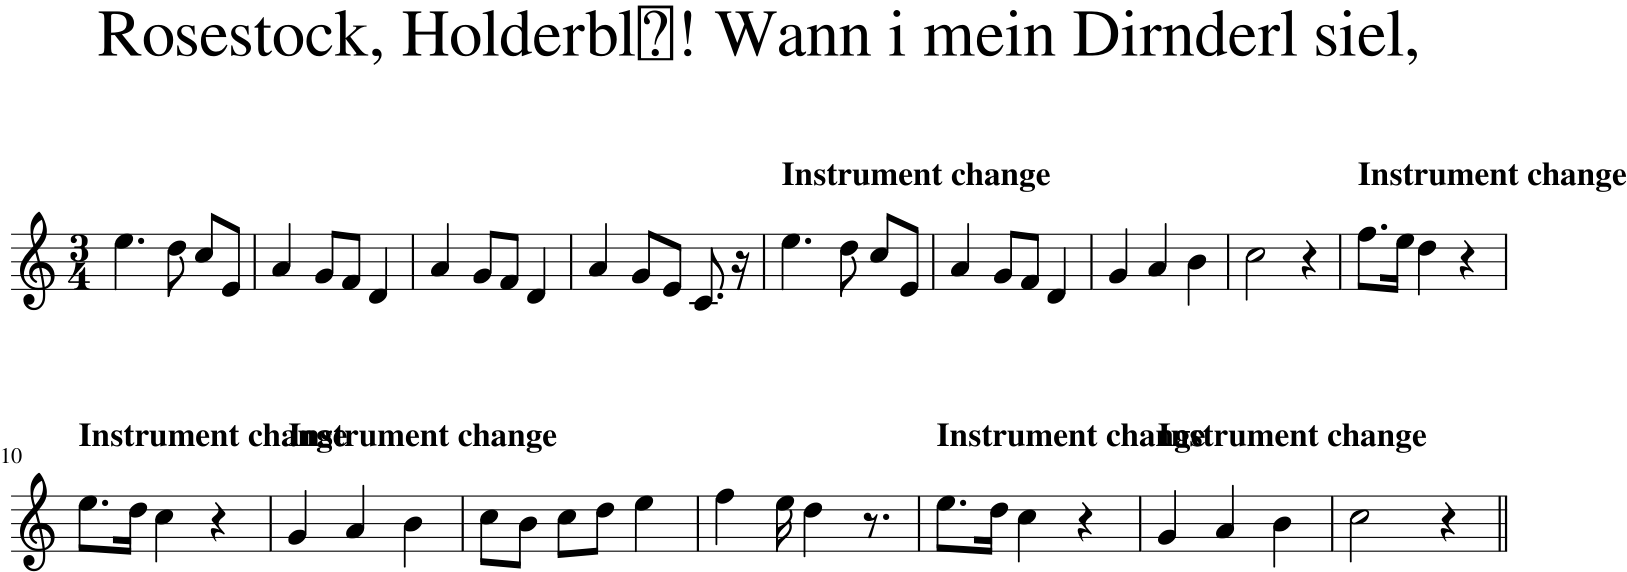

In [71]:
if __name__ == "__main__":
    m21.environment.set("musescoreDirectPNGPath", "/usr/bin/mscore")
    preprocess(KERN_DATASET_PATH)
    songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET)
    create_mapping(songs, MAPPING_FILE)
    inputs, targets = generating_training_sequences()

    # songs = load_songs(KERN_DATASET_PATH)
    # print(len(songs))
    # song = songs[0]
    # song.show()
    # transposed_song = transpose(song)
    # transposed_song.show()